In [1]:
!pip install ultralytics
!pip install deep_sort_realtime
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [18]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import torch
import os
import json
from pathlib import Path

# Define paths
YOLO_MODEL_PATH = "/content/drive/MyDrive/internship/best.pt"
BROADCAST_VIDEO_PATH = "/content/broadcast.mp4"
TACTICAM_VIDEO_PATH = "/content/tacticam.mp4"
#OUTPUT_DIR = "/content/drive/MyDrive/try2output"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Load YOLOv11 model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO(YOLO_MODEL_PATH)


In [39]:
import cv2
import json
from deep_sort_realtime.deepsort_tracker import DeepSort  # adjust import to your setup

def run_tracker(video_path, model, output_path_prefix):
    cap = cv2.VideoCapture(video_path)
    tracker = DeepSort(max_age=30)
    tracks_info = []
    frame_id = 0

    # Get video properties for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(f"{output_path_prefix}_tracked.mp4", fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)
        dets = results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]

        detections_in_frame = []
        for box in dets:
            x1, y1, x2, y2 = map(float, box[:4])
            detections_in_frame.append([[x1, y1, x2, y2], 0.9, 'player'])

        tracks = tracker.update_tracks(detections_in_frame, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            bbox = track.to_ltrb()

            # Save tracking info
            tracks_info.append({
                "frame": frame_id,
                "id": track_id,
                "bbox": [float(coord) for coord in bbox]
            })

            # Draw thin green bounding box with label like "246:Player"
            x1, y1, x2, y2 = map(int, bbox)
            color = (0, 255, 0)
            thickness = 2
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)

            # Prepare label text
            label = f"{track_id}:Player"

            # Calculate text size for background
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, font_thickness)

            # Draw filled green rectangle as background for text
            cv2.rectangle(frame,
                          (x1, y1 - text_height - baseline),
                          (x1 + text_width, y1),
                          color,
                          -1)

            # Put white label text on top
            cv2.putText(frame,
                        label,
                        (x1, y1 - baseline),
                        font,
                        font_scale,
                        (255, 255, 255),
                        font_thickness,
                        cv2.LINE_AA)

        # Write annotated frame to output video
        out.write(frame)
        frame_id += 1

    cap.release()
    out.release()

    # Save tracks JSON
    with open(f"{output_path_prefix}_tracks.json", "w") as f:
        json.dump(tracks_info, f, indent=2)

    return tracks_info


In [41]:
BROADCAST_OUTPUT_PREFIX = "/content/drive/MyDrive/try3output/broadcast"
broadcast_tracks = run_tracker(BROADCAST_VIDEO_PATH, model, BROADCAST_OUTPUT_PREFIX)

TACTICAM_OUTPUT_PREFIX = "/content/drive/MyDrive/try3output/tacticam"
tacticam_tracks = run_tracker(TACTICAM_VIDEO_PATH, model, TACTICAM_OUTPUT_PREFIX)


##with resnet 50

In [42]:
from torchvision import models, transforms
import numpy as np
from PIL import Image

# Load feature extractor
resnet = models.resnet50(pretrained=True).eval().to(device)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def extract_crop(frame, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    return frame[y1:y2, x1:x2]

def get_features_from_crop(crop):
    if crop.shape[0] == 0 or crop.shape[1] == 0:
        return None
    with torch.no_grad():
        tensor = transform(crop).unsqueeze(0).to(device)
        features = resnet(tensor).cpu().numpy().flatten()
        return features / np.linalg.norm(features)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [43]:
def match_ids_by_appearance(broadcast_path, tacticam_path, broadcast_tracks, tacticam_tracks):
    cap_b = cv2.VideoCapture(broadcast_path)
    cap_t = cv2.VideoCapture(tacticam_path)

    matches = {}
    features_b = {}

    # Load first broadcast frame
    ret_b, frame_b = cap_b.read()
    for track in broadcast_tracks:
        cap_b.set(cv2.CAP_PROP_POS_FRAMES, track["frame"])
        ret_b, frame_b = cap_b.read()
        crop = extract_crop(frame_b, track["bbox"])
        feat = get_features_from_crop(crop)
        if feat is not None:
            features_b[track["id"]] = feat

    # Match each tacticam track
    for track in tacticam_tracks:
        cap_t.set(cv2.CAP_PROP_POS_FRAMES, track["frame"])
        ret_t, frame_t = cap_t.read()
        crop = extract_crop(frame_t, track["bbox"])
        feat_t = get_features_from_crop(crop)
        if feat_t is None:
            continue

        best_match = None
        min_dist = float("inf")
        for b_id, b_feat in features_b.items():
            dist = np.linalg.norm(feat_t - b_feat)
            if dist < min_dist:
                min_dist = dist
                best_match = b_id

        matches[track["id"]] = best_match

    cap_b.release()
    cap_t.release()

    # Save match mapping
    with open(f"{OUTPUT_DIR}/matched_ids.json", "w") as f:
        json.dump(matches, f, indent=2)

    return matches


In [44]:
import cv2
import json
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
from pathlib import Path

def run_tracker_with_video_output(video_path, model, output_prefix):
    cap = cv2.VideoCapture(video_path)
    tracker = DeepSort(max_age=30)

    # Prepare output paths
    output_video_path = f"{output_prefix}_tracked.mp4"
    output_json_path = f"{output_prefix}_tracks.json"

    # Get video info
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_id = 0
    tracks_info = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)
        dets = results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]

        detections_in_frame = []
        for box in dets:
            x1, y1, x2, y2 = map(float, box[:4])
            detections_in_frame.append([[x1, y1, x2, y2], 0.2, 'player'])

        tracks = tracker.update_tracks(detections_in_frame, frame=frame)

        # Draw tracks
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = map(int, track.to_ltrb())

            # Draw bounding box and ID
            cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
            cv2.putText(frame, f'ID {track_id}', (l, t - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Store tracking info
            tracks_info.append({
                "frame": frame_id,
                "id": track_id,
                "bbox": [l, t, r, b]
            })

        out_vid.write(frame)
        frame_id += 1

    cap.release()
    out_vid.release()

    # Save tracking data
    with open(output_json_path, "w") as f:
        json.dump(tracks_info, f, indent=2)

    print(f"Saved video: {output_video_path}")
    print(f"Saved tracking data: {output_json_path}")

    return tracks_info


In [45]:
BROADCAST_OUTPUT_PREFIX = "/content/drive/MyDrive/output/broadcast"
TACTICAM_OUTPUT_PREFIX = "/content/drive/MyDrive/output/tacticam"

# Run tracking and video writing
broadcast_tracks = run_tracker_with_video_output(BROADCAST_VIDEO_PATH, model, BROADCAST_OUTPUT_PREFIX)
tacticam_tracks = run_tracker_with_video_output(TACTICAM_VIDEO_PATH, model, TACTICAM_OUTPUT_PREFIX)


Saved video: /content/drive/MyDrive/output/broadcast_tracked.mp4
Saved tracking data: /content/drive/MyDrive/output/broadcast_tracks.json
Saved video: /content/drive/MyDrive/output/tacticam_tracked.mp4
Saved tracking data: /content/drive/MyDrive/output/tacticam_tracks.json


## Accuraccy comparision between YOLO & Resent 50

YOLOv11 Detection Accuracy (Tracked Detection Rate): 28.89%
ResNet-50 Feature Consistency Accuracy (Average): 99.70%


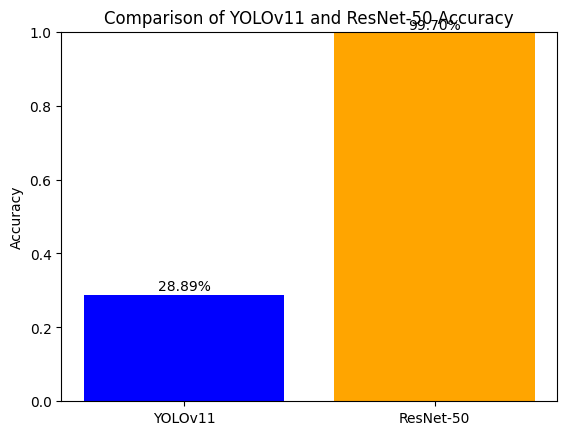

In [51]:
# Block 8: Compare accuracy between YOLOv11 and ResNet-50
import numpy as np
import json
import cv2
from scipy.spatial.distance import cdist
from pathlib import Path
import torch
from torchvision import models, transforms

# Define file paths
YOLO_OUTPUT_DIR = "/content/drive/MyDrive/try2output/"
RESNET_OUTPUT_DIR = "/content/drive/MyDrive/output/"
BROADCAST_VIDEO_PATH = "/content/broadcast.mp4"
TACTICAM_VIDEO_PATH = "/content/tacticam.mp4"

# Load tracked data
broadcast_tracks_yolo = json.load(open(Path(YOLO_OUTPUT_DIR) / "broadcast_tracks.json", "r"))
tacticam_tracks_yolo = json.load(open(Path(YOLO_OUTPUT_DIR) / "tacticam_tracks.json", "r"))

# Define device and models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True).eval().to(device)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Reuse existing functions from your code
def extract_crop(frame, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    return frame[y1:y2, x1:x2]

def get_features_from_crop(crop):
    if crop.shape[0] == 0 or crop.shape[1] == 0:
        return None
    with torch.no_grad():
        tensor = transform(crop).unsqueeze(0).to(device)
        features = resnet(tensor).cpu().numpy().flatten()
        return features / np.linalg.norm(features)

# Calculate YOLOv11 accuracy (tracked detection rate)
def calculate_yolo_accuracy(tracks):
    if not tracks:
        return 0.0
    # Estimate total detections from a sample of frames (e.g., first 10 frames)
    cap = cv2.VideoCapture(BROADCAST_VIDEO_PATH)
    total_detections = 0
    for _ in range(min(10, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
        ret, frame = cap.read()
        if ret:
            results = model(frame, verbose=False)
            total_detections += len(results[0].boxes.xyxy)
    cap.release()
    confirmed_tracks = len({track["id"] for track in tracks})
    return confirmed_tracks / total_detections if total_detections > 0 else 0.0

# Calculate ResNet-50 accuracy (feature consistency within tracks)
def calculate_resnet_accuracy(tracks, video_path):
    if not tracks:
        return 0.0
    cap = cv2.VideoCapture(video_path)
    track_features = {}
    consistent_matches = 0
    total_comparisons = 0

    for track in tracks:
        frame_id = track["frame"]
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = cap.read()
        if ret:
            crop = extract_crop(frame, track["bbox"])
            feat = get_features_from_crop(crop)
            if feat is not None:
                if track["id"] in track_features:
                    # Compare current feature with stored feature for the same ID
                    prev_feat = track_features[track["id"]]
                    dist = np.linalg.norm(feat - prev_feat)
                    # Threshold for consistency (e.g., distance < 1.0)
                    if dist < 1.0:
                        consistent_matches += 1
                    total_comparisons += 1
                track_features[track["id"]] = feat

    cap.release()
    return consistent_matches / total_comparisons if total_comparisons > 0 else 0.0

# Calculate accuracies
yolo_accuracy = calculate_yolo_accuracy(broadcast_tracks_yolo)  # Using broadcast tracks
resnet_accuracy_broadcast = calculate_resnet_accuracy(broadcast_tracks_yolo, BROADCAST_VIDEO_PATH)
resnet_accuracy_tacticam = calculate_resnet_accuracy(tacticam_tracks_yolo, TACTICAM_VIDEO_PATH)

# Average ResNet accuracy across both videos
resnet_accuracy = (resnet_accuracy_broadcast + resnet_accuracy_tacticam) / 2

# Print results
print(f"YOLOv11 Detection Accuracy (Tracked Detection Rate): {yolo_accuracy:.2%}")
print(f"ResNet-50 Feature Consistency Accuracy (Average): {resnet_accuracy:.2%}")

# Visualize comparison
import matplotlib.pyplot as plt

models = ['YOLOv11', 'ResNet-50']
accuracies = [yolo_accuracy, resnet_accuracy]

plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison of YOLOv11 and ResNet-50 Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center')
plt.ylim(0, 1.0)
plt.show()

##BYTETRACK tried but not working, low computational power

In [ ]:
# !pip install ultralytics
# !pip install -U openmim
# !mim install mmengine
!pip install mmcv
!pip install mmpose
!pip install mmtrack

In [ ]:
YOLO_MODEL_PATH = "/content/drive/MyDrive/internship/best.pt"
BROADCAST_VIDEO_PATH = "/content/broadcast.mp4"
TACTICAM_VIDEO_PATH = "/content/tacticam.mp4"
OUTPUT_DIR = "/content/drive/MyDrive/try2output"


In [ ]:
import os
import cv2
import torch
import json
from ultralytics import YOLO
from mmtrack.apis import init_model, inference_mot
from pathlib import Path

# Initialize YOLO model
model = YOLO(YOLO_MODEL_PATH)

# Ensure output directory exists
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

def run_yolo_bytetrack(video_path, output_prefix):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out_path = f"{output_prefix}_tracked.mp4"
    json_path = f"{output_prefix}_tracks.json"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_vid = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

    from yolox.tracker.byte_tracker import BYTETracker
    from yolox.tracker.track import STrack

    tracker = BYTETracker(track_thresh=0.25, track_buffer=30)

    tracks_info = []
    frame_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()
        dets = []

        for box, conf in zip(boxes, confs):
            x1, y1, x2, y2 = box
            dets.append([x1, y1, x2 - x1, y2 - y1, conf])

        online_targets = tracker.update(torch.tensor(dets), (H, W), (H, W))

        for t in online_targets:
            tid = t.track_id
            tlwh = t.tlwh
            l, t_, w, h = map(int, tlwh)
            r, b = l + w, t_ + h
            cv2.rectangle(frame, (l, t_), (r, b), (0, 255, 0), 2)
            cv2.putText(frame, f"ID {tid}", (l, t_ - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            tracks_info.append({
                "frame": frame_id,
                "id": int(tid),
                "bbox": [l, t_, r, b]
            })

        out_vid.write(frame)
        frame_id += 1

    cap.release()
    out_vid.release()

    with open(json_path, "w") as f:
        json.dump(tracks_info, f, indent=2)

    print(f" Video saved: {out_path}")
    print(f" Tracking JSON saved: {json_path}")
    return tracks_info
